In [40]:
import Test.@test
import Test.@testset

import LinearAlgebra: Diagonal, tr

import Keldysh; kd = Keldysh;

import KeldyshED; ked = KeldyshED;
import KeldyshED.Hilbert;
import KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf: atomic_ppgf, operator_product

In [187]:
β = 1.
μ = -0.5

H = μ * op.n("0")    
soi = KeldyshED.Hilbert.SetOfIndices([["0"]]);
ed = KeldyshED.EDCore(H, soi)
    
ρ = KeldyshED.density_matrix(ed, β)
    
# Real-time Kadanoff-Baym contour
    
contour = kd.twist(kd.Contour(kd.full_contour, tmax=5., β=β));
grid = kd.TimeGrid(contour, npts_real=5, npts_imag=10);
    
# Single particle Green's function
    
oidx = KeldyshED.Hilbert.IndicesType(["0"])
    
g = KeldyshED.computegf(ed, grid, [(oidx, oidx)], β)[1];
G0 = atomic_ppgf(grid, ed, β);

# -- Add fermionic sign change on pseud-particle propagator for sector 1

tau_grid = grid[kd.imaginary_branch]
z_i, z_f = tau_grid[1], tau_grid[end]
G0[1].data[1, 1, z_f.idx+1:end, 1:z_f.idx] *= -1.;

In [188]:
# Check that propagation from 
# - t on fwd branch over t_max 
# - to the same time t on bwd branch
# is unity

zb_max = grid[kd.backward_branch][1]
zf_max = grid[kd.forward_branch][end]

#println(real(zb_max.val.val), ", ", real(zf_max.val.val))

for (sidx, G_s) in enumerate(G0)
    #println("-----------")
    #println("sidx = $sidx")
    #println("-----------")
    for (zb, zf) in zip(reverse(grid[kd.backward_branch]), grid[kd.forward_branch])
        prod = im^2 * G_s[zb, zb_max] * G_s[zf_max, zf]
        @test prod ≈ [1.]
        #println(real(zb.val.val), ", ", real(zf.val.val), " : ", prod)
    end
end

# Visualization

In [189]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [190]:
extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

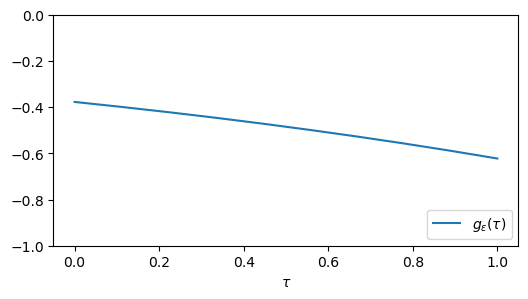

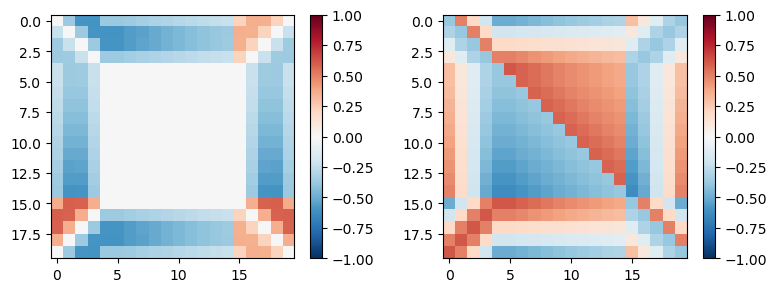

In [191]:
τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, g[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plot2d(g.data)

In [192]:
ed

Dimension of full Hilbert space: 2
Number of invariant subspaces: 2
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.5]
Ground state energy: -0.5


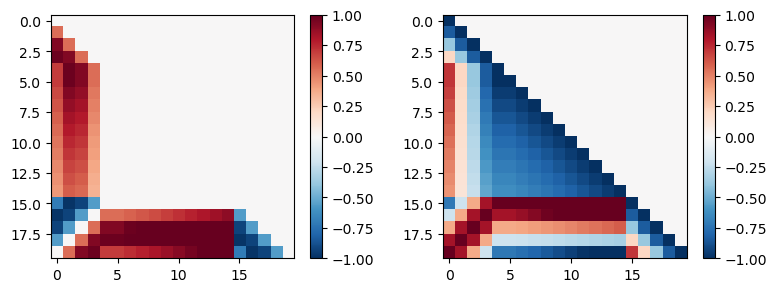

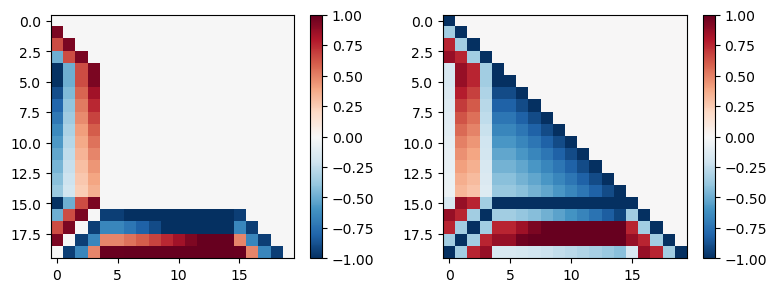

In [193]:
plot2d(G0[1].data[1, 1, :, :])
plot2d(G0[2].data[1, 1, :, :])

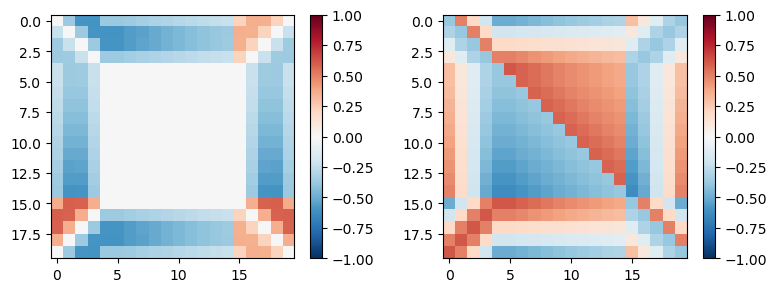

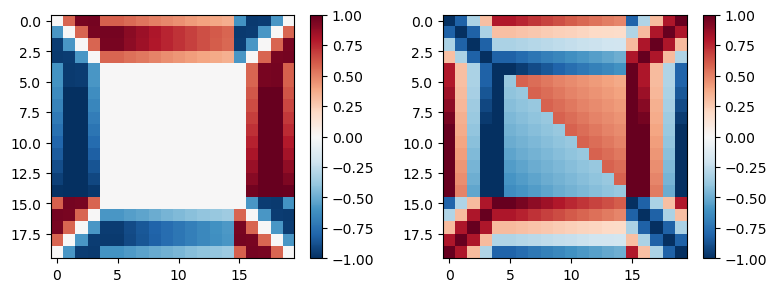

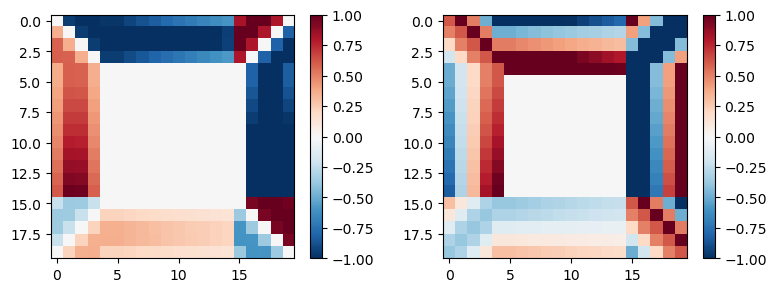

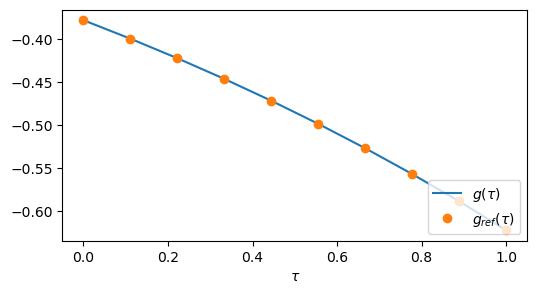

In [195]:
# -- Compute atomic single-particle Green's function
# -- using pseudo-particle propagator

g_ref = copy(g)
g_ref.data .= 0

for z1 in grid, z2 in grid

    # Creation/annihilator operator commutation sign
    sign = 1 - 2 * (z1.idx <= z2.idx)

    # Operator verticies
    v1 = (z1, +1, oidx)
    v2 = (z2, -1, oidx)
    
    # (twisted contour) time ordered operator verticies
    v1, v2 = sort([v1, v2], by = x -> x[1].idx, rev=false)

    # -- Determine start and end time on twisted contour
    
    if z1.val.domain == kd.imaginary_branch && z2.val.domain == kd.imaginary_branch
        
        # Equilibrium start at \tau = 0 and end at \tau = \beta
        
        tau_grid = grid[kd.imaginary_branch]
        z_i, z_f = tau_grid[1], tau_grid[end]
    else
        
        # Atleast one time is in real-time 
        
        # find maximum real-time
        t_max = maximum([real(z1.val.val), real(z2.val.val)])
        
        # Set start time on bwd branch and end time on fwd branch to t_max
        grid_bwd, grid_fwd = grid[kd.backward_branch], grid[kd.forward_branch]
        z_i = grid_bwd[findfirst(x -> x.val.val == t_max, grid_bwd)]
        z_f = grid_fwd[findfirst(x -> x.val.val == t_max, grid_fwd)]
        
        #println("t_max = $t_max, z_i, z_f = $(z_i.idx), $(z_f.idx)")
    end
    
    @test z_f.idx >= v2[1].idx
    @test v2[1].idx >= v1[1].idx
    @test v1[1].idx >= z_i.idx
    
    for (sidx, s) in enumerate(ed.subspaces)
        prod = operator_product(ed, G0, sidx, z_i, z_f, [v1, v2])
        g_ref[z2, z1] += im * sign * tr(prod)
    end
end

plot2d(g.data)
plot2d(g_ref.data)

plot2d(g.data - g_ref.data)

τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, real(g[:matsubara]), label=plt.L"$g(\tau)$")
plt.plot(τ, real(g_ref[:matsubara]), "o", label=plt.L"$g_{ref}(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); #plt.ylim([-1., 0]);
